In [1]:
from z3 import *
import numpy as np
import random
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

# our library
from src.mcmc_sat import smt,mcmc

ModuleNotFoundError: No module named 'z3'

## Model definition (in Z3)

We start by defining a model as an SMT problem using Z3

In [4]:
# We create five Integer variables
num_vars = 5*2
x = [Int(f'x{i}') for i in range(num_vars)] # (age, sex)

In [5]:
# We define the model using the variables above

s = Solver() # get an instance of a Z3 solver

# model constraints
# s.add(x[2]==30)
# s.add(x[0]<=30)
# s.add(x[1]<=30)
# s.add(x[0]>=0)
# s.add(x[1]>=0)
# s.add(x[3]<=125)
# s.add(x[4]<=125)
# s.add(30<=x[3])
# s.add(30<=x[4])
# s.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5)

# model constraints (alternative)
s.add(0<=x[0])
s.add(x[0]<=x[1])
s.add(x[1]<=x[2])
s.add(x[2]==30) #  median
s.add(x[2]<=x[3])
s.add(x[3]<=x[4])
s.add(x[4]<=125)

s.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) #average

for i in range(5,10):
    s.add(0<=x[i])
    s.add(x[i]<=1)

s.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

s.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males


## Storing the model

We store the Z3 problem in a smt2 format. This is the input format required by Megasampler.

In [6]:
MEGASAMPLER_INPUT_DIR = 'megasampler_input'
megasampler_input_file = 'z3_problem.smt2'
megasampler_input_filepath = f'{MEGASAMPLER_INPUT_DIR}/{megasampler_input_file}'

smt.save_smt2(solver=s, filepath=megasampler_input_filepath)

## Executing Megasampler

Now we execute megasampler to produce 10000 samples (by default). The input to the function is the file where the smt2 version of the Z3 problem is stored.

In [7]:
# We execute megasampler \o/
MEGASAMPLER_OUTPUT_DIR = 'megasampler_output'
smt.execute_megasampler(input_filepath=megasampler_input_filepath,
                        output_dir=MEGASAMPLER_OUTPUT_DIR)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 20
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 6
--------------------------------------------
starting MeGASampler


Formula is satisfiable
MAX-SMT returned 'unknown' (timeout?)
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 1196.59
epoch time: 1799.87
grow_seed time: 57.8148
initial_solving time: 0.0151628
output time: 3.41681
start_epoch time: 603.029
total time: 1800.01
Epochs: 139584
MAX-SMT calls: 139585
SMT calls: 1
Assignments considered (with repetitions): 14237568
Models (with repetitions): 14237568
Unique models (# samples in file): 549
-----------------------------------


Megasampler stores the samples in a file. The file is stored in the directory passed as parameter in the above function. In what follows, we parse this file to produce a list of samples. Each sample is encoded as a dictionary where the key is the variable name and the value the sample.

In [8]:
# Define output files with samples
file_samples = f'{MEGASAMPLER_OUTPUT_DIR}/{megasampler_input_file}.samples'

In [9]:
# We parse the samples
samples = smt.parse_megasamples(file_samples)

## We run our MCMC algo

Finally, we run our MCMC algorithm. It takes as input the parsed samples. Currently, we always accept the samples. There is no likelihood or prior.

In [10]:
# We run MCMC using the "megasamples"
trace = mcmc.sample_mh_trace(10000,4,samples)

The parameter `solver_samples` only contains 549 samples. Thus, every chain will contain 549 instead of 10000. Try running the SAT/SMT sampler longer to obtain more samples.


## Posterior

We conclude by showing the posterior trace plots and summary statistics for each variable.

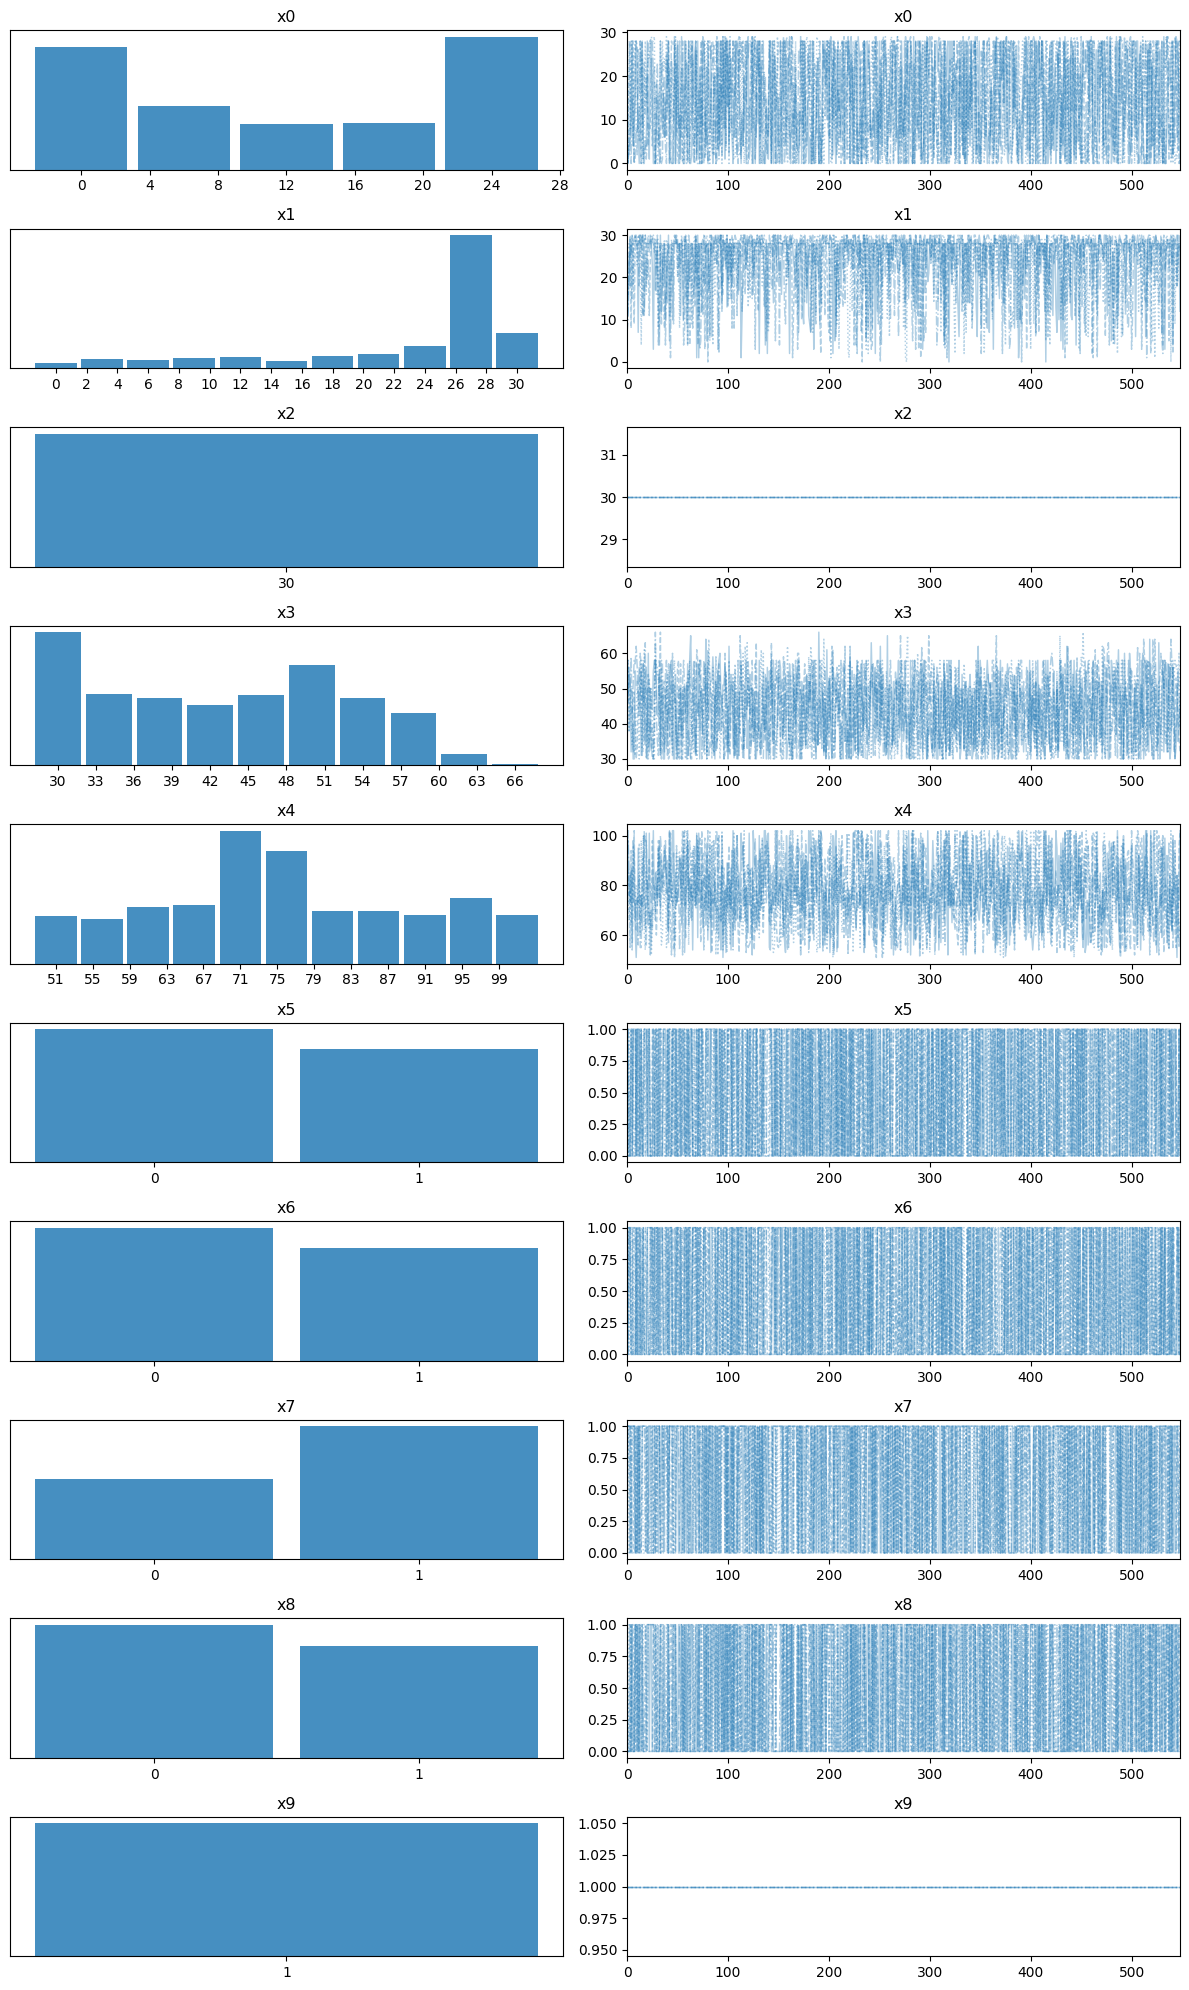

In [11]:
# Plot the posterior
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [12]:
# Diagnostics
az.summary(trace)

/home/pardo/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.379,10.938,0.0,28.0,0.244,0.173,2068.0,1976.0,1.0
x1,23.796,7.801,6.0,30.0,0.166,0.118,2272.0,2162.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,2192.0,2192.0,NaN
x3,44.064,9.723,30.0,58.0,0.203,0.143,2312.0,2149.0,1.0
x4,77.761,13.969,55.0,102.0,0.307,0.218,2083.0,2192.0,1.0
x5,0.461,0.499,0.0,1.0,0.011,0.008,2198.0,2192.0,1.0
x6,0.459,0.498,0.0,1.0,0.011,0.008,2165.0,2165.0,1.0
x7,0.623,0.485,0.0,1.0,0.010,0.007,2198.0,2192.0,1.0
x8,0.457,0.498,0.0,1.0,0.011,0.008,2154.0,2154.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,0.000,2192.0,2192.0,NaN
